# Comparison implementations of Minerva 2
Here I compare my own implementation in `minerva.py` with two other implementations in `alter_wrapper.py`, which is a Python wrapper based on `minerva2.py` and `minerva-al.R` in `alternative_implementations/`.

In [1]:
import numpy as np
import minerva as mine
import alter_wrapper as alter

## 1. Initialise models
We prepare the three models with 5 features per memory trace:

In [2]:
item_size = 5
model = [init_class(item_size) for init_class in [mine.Minerva2, alter.model1, alter.model2]]
[print(m) for m in model]

[None, None, None]

## 2. Train models
The models can learn individual training samples, one by one:

In [3]:
sample1 = [1,0,0,0,0]
sample2 = np.ones(5)
for m in model:
    m.learn(sample1)
    m.learn(sample2)
    print(m.get_memory_matrix())

[[1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
[[1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
[[1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]


They can also learn individual training samples in an aggregated manner:

In [4]:
samples1 = [[0,1,0,0,0],[0,0,1,0,0]]
samples2 = np.array([[-1,-1,0,0,0],[0,0,0,-1,-1]])
for m in model:
    m.reset() # reset the memory matrix to empty
    m.learn(samples1)
    m.learn(samples2)
    print(m.get_memory_matrix())

[[ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [-1. -1.  0.  0.  0.]
 [ 0.  0.  0. -1. -1.]]
[[ 0  1  0  0  0]
 [ 0  0  1  0  0]
 [-1 -1  0  0  0]
 [ 0  0  0 -1 -1]]
[[ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [-1. -1.  0.  0.  0.]
 [ 0.  0.  0. -1. -1.]]


## 3. Probe models
After training, we probe the models and compare their responses:

In [5]:
probe = np.ones(5)
for m in model:
    echo = m.respond(probe)
    print(echo)

[[0.88888889 1.         0.11111111 0.88888889 0.88888889]]
[[0.88888889 1.         0.11111111 0.88888889 0.88888889]]
[[0.88888889 1.         0.11111111 0.88888889 0.88888889]]


One can also test the models with multiple probes:

In [6]:
probes = [[0,-1,0,0,0],[1,0,1,0,1]]
for m in model:
    echos = m.respond(probes)
    print(echos)

[[-0.5 -1.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1. ]]
[[-0.5 -1.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1. ]]
[[-0.11111111 -1.          0.          0.          0.        ]
 [ 0.421875    0.421875    1.          0.421875    0.421875  ]]


One may note the disagreement between the 3rd model and the first 2 models.

Before having a fight, I aslo make sure one can have recurrence of echoes:

In [7]:
recurrence = 5
for m in model:
    re_echos = m.respond(probes, recurrence)
    print(re_echos)

[[-8.66084851e-01 -1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.66898651e-01  1.00000000e+00  5.34411088e-38  7.10354179e-02
   7.10354179e-02]]
[[-8.66084851e-01 -1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.66898651e-01  1.00000000e+00  5.34411088e-38  7.10354179e-02
   7.10354179e-02]]
[[-8.64186666e-01 -1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.66898651e-01  1.00000000e+00  1.22458365e-07  7.10354179e-02
   7.10354179e-02]]


It seems that as the recurrence number increases, the difference diminishes.

Q: Why do we have the difference in the first place?

A: It is likely due to different models are implementing Minerva 2 with slightly different binary similarity measures.

## 4. How different are these models?
Now I compare these models with 1000 features per memory trace, generate 10 random initial memories for them, and test them with 1000 probes:

In [8]:
num_feature = 100
bigmodel = [init_class(num_feature) for init_class in [mine.Minerva2, alter.model1, alter.model2]]

In [9]:
num_trace = 10
training_data = np.random.randint(-1, 2, size = (num_trace, num_feature)) # memory traces are random initialised with -1, 0, 1
[m.learn(training_data) for m in bigmodel]

[None, None, None]

In [10]:
num_test = 1000
test_data = np.random.uniform(-1, 1, size = (num_test, num_feature)) # test probes are random initialised between -1 and 1

To measure the differences, here I add up all differences within each echo (row), and calculate the average difference:

In [11]:
nums_rec = [1, 2, 5, 10, 20, 50, 100]
differences = []
for recurrence in nums_rec:
    bigechos = [m.respond(test_data, recurrence) for m in bigmodel]
    row_avg_d = [np.mean(np.sum(np.abs(be - bigechos[0]), axis = 1)) for be in bigechos[1:]] # my model gives bigechos[0], which is considered as a baseline
    differences.append(row_avg_d)

In [12]:
d = np.swapaxes(differences, 0, 1)

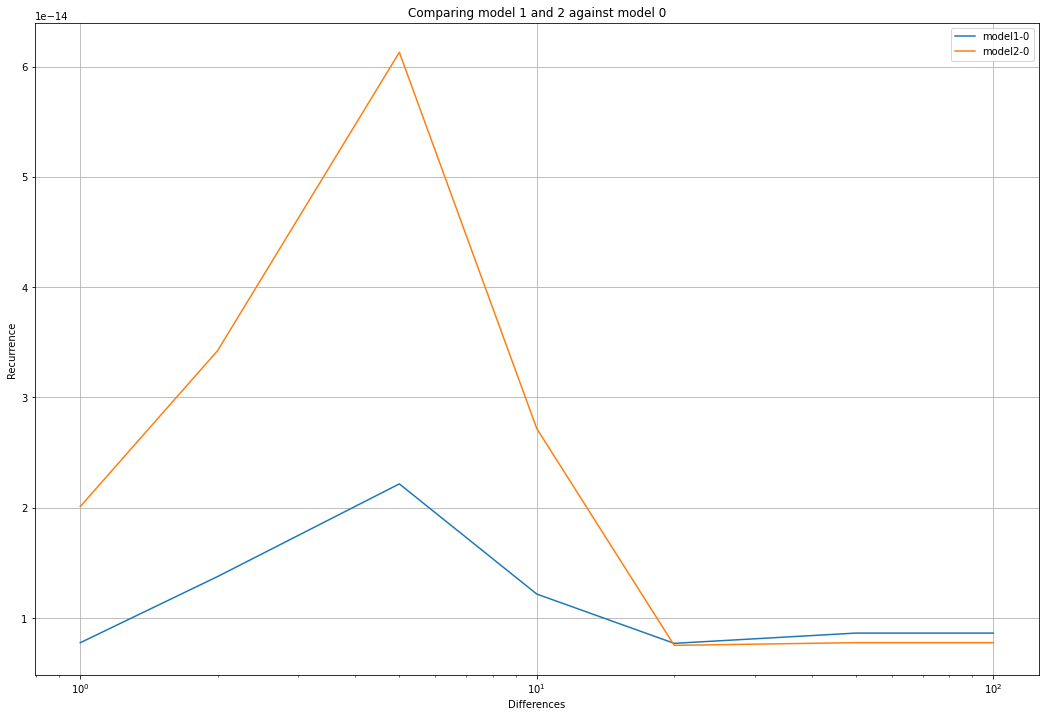

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (18, 12))
[ax.plot(nums_rec, row, label = l) for row, l in zip(d, ['model1-0', 'model2-0'])]
ax.set_title('Comparing model 1 and 2 against model 0')
ax.set_xscale('log')
ax.set_xlabel('Differences')
ax.set_ylabel('Recurrence')
ax.legend()
ax.grid()